In [16]:
import sys
sys.path.append('../../')

# from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from hnlpy.timeop import makefiltersos
from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.stats import sem
# from scipy.signal import savgol_filter
# from scipy.fftpack import fft
# from scipy import stats # for zscoring

from sklearn.covariance import GraphicalLassoCV

# from numpy.polynomial.polynomial import polyfit, polyval

import matplotlib.pyplot as plt

In [2]:
# load data
def loaddata(filename):
    data = loadmat(filename)
    bpchan = int(data['bpchan'][0][0])
    channels = data['channels'][0]
    conditionNames = data['conditionNames'][0]
    conditions = data['conditions'][0]
    eeg = dict()
    eeg[0] = data['dataL'][0]
    eeg[1] = data['dataR'][0]
    intervals = data['intervals'][0]
    labels = data['labels'][0]
    samples = data['samples'][0]
    session = int(data['session'][0])
    sessionTypes = data['sessionTypes'][0]
    sr = int(data['sr'][0])
    #Labels and condition names doesnt come over cleanly from matlab 
    chan_labels = list()
    condition_Names = list()
    #pythonify condition index
    condition_index = list()
    for j in range(len(labels)):
        chan_labels.append(labels[j][0])
    for j in range(len(conditionNames)):
        condition_Names.append(conditionNames[j][0])
    for j in range(12):
        condition_index.append(int(conditions[j]-1))
    return eeg, intervals, samples, condition_index, session, sr, bpchan, condition_Names, channels, chan_labels, sessionTypes 

In [3]:
def avref(datax):
	ref = np.mean(datax,axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	return datax

In [4]:
# build the narrow band filters
srnew = 200 
downsample = 10 
passbands = [[1,3],[3.5,6.5],[7,10],[10.5,13.5],[14 ,20],[21,29],[30,49.5]]
stopbands = [[0.75,3.25],[3.25,6.75],[6.75,10.25],[10.25,13.75],[13.75,20.5],[20.5,29.5],[29.5,50]]
bandlabels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']
esos = dict()
for j in range(len(passbands)):
    esos[j],w,h = narrowfilter(passbands[j],stopbands[j],samplingrate = srnew)

In [5]:
def convergence_test(fval, previous_fval, threshold=1e-4, warn=False):
    """
    Check if an objective function has converged.

    We have converged if the slope of the function falls below 'threshold',
    i.e., |f(t) - f(t-1)| / avg < threshold,
    where avg = (|f(t)| + |f(t-1)|)/2.
    'threshold' defaults to 1e-4.
    This stopping criterion is from Numerical Recipes in C p423.
    """

    converged = False
    delta_fval = np.abs(fval - previous_fval)
    avg_fval = (np.abs(fval) + np.abs(previous_fval) + np.finfo(float).eps) / 2

    if delta_fval / avg_fval < threshold:
        converged = True

    if warn and (fval - previous_fval) < -2 * np.finfo(float).eps:  # fval < previous_fval
        warnings.warn('objective decreased!', UserWarning)

    return converged

In [6]:
def ggmFitHtf(S, G, maxIter=30):
    # MLE for a precision matrix given known zeros in the graph
    # S is d*d sample covariance matrix
    # G is d*d adjacency matrix
    # We use the algorithm due to 
    # Hastie, Tibshirani & Friedman ("Elements" book, 2nd Ed, 2008, p633)
    # This file is from pmtk3.googlecode.com
    p = S.shape[0] 
    W = S # W = inv(precMat)
    precMat = np.zeros((p, p))
    beta = np.zeros(p-1)
    iter = 1
    converged = False
    normW = np.linalg.norm(W)
    while not converged:
        for i in range(p):
            # partition W & S for i
            noti = np.concatenate((np.arange(i), np.arange(i+1, p)))
            W11 = W[noti,:][:,noti]
            w12 = W[noti,i]
            s22 = S[i,i]
            s12 = S[noti,i]

            # find G's non-zero index in W11
            idx = np.nonzero(G[noti,i])[0]  # non-zeros in G11
            beta[:] = 0
            beta[idx] = np.linalg.solve(W11[np.ix_(idx,idx)], s12[idx])

            # update W
            w12 = W11 @ beta
            W[noti,i] = w12 
            W[i,noti] = w12

            # update precMat (technically only needed on last iteration)
            p22 = max([0,  1/(s22 - w12 @ beta)])  # must be non-neg
            p12 = -beta * p22
            precMat[noti,i] = p12
            precMat[i,noti] = p12
            precMat[i,i] = p22

        converged = convergence_test(np.linalg.norm(W),normW) | (iter > maxIter)
        normW = np.linalg.norm(W)
        iter += 1

    # ensure symmetry 
    precMat = (precMat + precMat.T)/2
    
    return precMat, iter


In [8]:
# load pcorr_subj from the 7 band model
outdict = loadmat('eeg_7band_pacorr.mat')
eeg_7band_pacorr = outdict['eeg_7band_pacorr']

In [7]:
# organize file in time sequence
filedir="../../"
pathname = 'Cleaned_data/'
filedates=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
numSes=len(filedates)

In [14]:
re_parcor_all=np.zeros([12,12,2,7,32,32])
iter_all=np.zeros([12,12,2,7])
outdict = dict()
for ses in range(12):
    filename='clean_'+str(filedates[ses])+'.mat'
    [eeg, intervals, samples, condition_index, session, sr, bpchan, 
                condition_Names, channels, chan_labels, sessionTypes] \
                    = loaddata(filedir+pathname+filename)
    #make a low pass filter @ 50 Hz 
    sos_low, w,h = makefiltersos(sr,50,55)
    empirical_ampcorr = np.zeros((12,2,7,32,32))
    parcor = np.zeros((12,2,7,32,32))
    for trial in range(12):
        nsamp1 = np.shape(eeg[0][trial])[0]
        nsamp2 = np.shape(eeg[1][trial])[0]
        nsamp = np.min((nsamp1,nsamp2))
        for subject in range(2): 
            trialdata = avref(eeg[subject][trial][0:nsamp,0:32]) 
            trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
            trialdatanew = trialdata[range(0,nsamp,downsample),:]
            for frequency in range(7):
                        filtdata = sosfiltfilt(esos[frequency],trialdatanew,axis = 0,padtype ='odd')
                        hilbertdata = hilbert(filtdata,axis = 0)
                        ampdata=np.abs(hilbertdata)
                        empirical_ampcorr[trial,subject,frequency,:,:] = \
                            np.corrcoef(np.transpose(ampdata))
                        # single trial in one session
                        S = empirical_ampcorr[trial,subject,frequency,:,:]
                        # freq band model
                        x = eeg_7band_pacorr[frequency,:,:]
                        G = x.astype('bool')
                        G = G.astype('int')
                        # re-estimate
                        precMat,iter = ggmFitHtf(S, G, maxIter=100)
                        y = np.diag(precMat)
                        yy = np.outer(y,y)
                        yy = np.sqrt(yy)
                        parcor = precMat/yy 
                        re_parcor_all[ses,trial,subject,frequency,:,:]=parcor
                        iter_all[ses,trial,subject,frequency]=iter

# take 7 min

In [19]:
# save
outdict=dict()
outdict['re_parcor_all']=re_parcor_all
outdict['iter_all']=iter_all
savemat('re_estimate',outdict,store_python_metadata=True)

In [9]:
# load reestimate corr
outdict = loadmat('re_estimate.mat')
re_parcor_all=outdict['re_parcor_all'] # 12x12x2x7x32x32


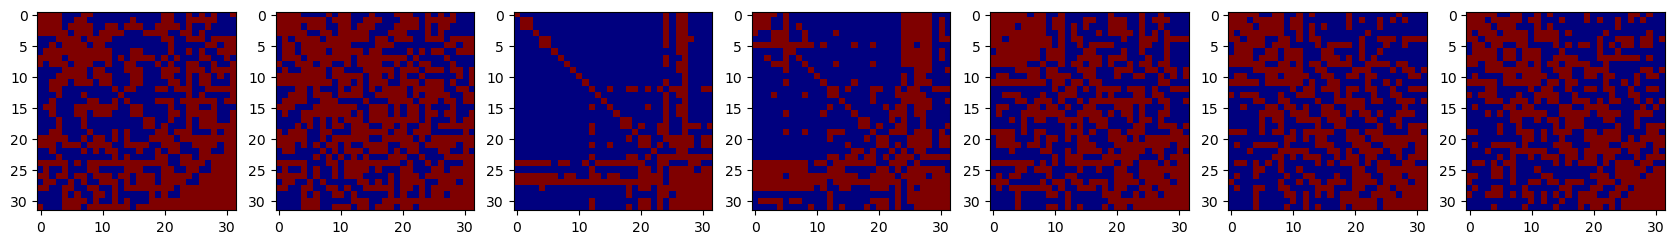

In [10]:
# examine the bool map
fig, ax = plt.subplots(1,7,figsize=(3*7, 3))
for freq in range(7):
    plt.sca(ax[freq])
    plt.imshow(re_parcor_all[1,1,1,freq,:,:].astype(bool),cmap='jet')

In [21]:
# put re_parcor_all and everything in 144 first dimenstion 
eeg_re_parcor144x2     =np.zeros((144,2,7,32,32))
condition_index144   =np.zeros((144))
intervals144         =dict()
samples144           =dict()
session144           =np.zeros((144))
n=0
for ses in range(12):
    outdict = loadmat('../Filter_Hilbert/Corr_eeg_200_'+str(filedates[ses])+'.mat')
    condition_index     = outdict['condition_index']    # 12
    intervals           = outdict['intervals']          # 12x~175x2
    samples             = outdict['samples']            # 12x~175x2
    session             = outdict['session']            # 12
    for trl in range(12):
        condition_index144[n]     = condition_index[trl]    # 12
        intervals144[str(n)]      = intervals[trl]
        samples144[str(n)]        = samples[trl]
        session144[n]             = session[trl]
        for subj in range(2):
            eeg_re_parcor144x2[n,subj,:,:,:]     = re_parcor_all[ses,trl,subj,:,:,:]
            
        n+=1

outdict = dict()
outdict['eeg_re_parcor144x2']     = eeg_re_parcor144x2
outdict['condition_index144']   = condition_index144
outdict['intervals144']         = intervals144
outdict['samples144']           = samples144
outdict['session144']           = session144
savemat('eeg_re_parcor144x2',outdict,store_python_metadata = True) 


In [17]:
# # organize indicies
# synch_ind=np.where(session144==1)
# synco_ind=np.where(session144==2)

# Uncoupled_ind=np.where(condition_index144==0)
# L_lead_ind   =np.where(condition_index144==1)
# R_lead_ind   =np.where(condition_index144==2)
# Mutual_ind   =np.where(condition_index144==3)

# # Uncoupled condition in Synch for L&R
# Uncoupled_synch_ind=np.intersect1d(synch_ind,Uncoupled_ind)
# # Uncoupled condition in Synco for L&R
# Uncoupled_synco_ind=np.intersect1d(synco_ind,Uncoupled_ind)


# # L_Leading in Synch / R_following in Synch
# L_lead_synch_ind=np.intersect1d(synch_ind,L_lead_ind)
# # R_leading in Synch / L_following in Synch
# R_lead_synch_ind=np.intersect1d(synch_ind,R_lead_ind)
# # L_Leading in Synco / R_following in Synco
# L_lead_synco_ind=np.intersect1d(synco_ind,L_lead_ind)
# # R_leading in Synco / L_following in Synco
# R_lead_synco_ind=np.intersect1d(synco_ind,R_lead_ind)


# # Mutual condition in Synch for L&R
# Mutual_synch_ind=np.intersect1d(synch_ind,Mutual_ind)
# # Mutual condition in Synco for L&R
# Mutual_synco_ind=np.intersect1d(synco_ind,Mutual_ind)

In [18]:
# # eeg_re_parcor144x2 # 144x2x7x32x32
# eeg_pcorr_mean2x4x7=np.zeros((2,4,7,32,32)) # 2 syn types x 4 condi x 7 freq x 32 chan

# for freq in range(7):
#     # Uncoupled
#     eeg_pcorr_mean2x4x7[0,0,freq,:,:]=np.mean(np.concatenate((eeg_re_parcor144x2[Uncoupled_synch_ind,0,freq,:,:], \
#                                             eeg_re_parcor144x2[Uncoupled_synch_ind,1,freq,:,:]),axis=0),axis=0)
#     eeg_pcorr_mean2x4x7[1,0,freq,:,:]=np.mean(np.concatenate((eeg_re_parcor144x2[Uncoupled_synco_ind,0,freq,:,:], \
#                                             eeg_re_parcor144x2[Uncoupled_synco_ind,1,freq,:,:]),axis=0),axis=0)

#     # Leading for L&R
#     eeg_pcorr_mean2x4x7[0,1,freq,:,:]=np.mean(np.concatenate((eeg_re_parcor144x2[L_lead_synch_ind,0,freq,:,:],\
#                                             eeg_re_parcor144x2[R_lead_synch_ind,1,freq,:,:]),axis=0),axis=0)
#     eeg_pcorr_mean2x4x7[1,1,freq,:,:]=np.mean(np.concatenate((eeg_re_parcor144x2[L_lead_synco_ind,0,freq,:,:],\
#                                             eeg_re_parcor144x2[R_lead_synco_ind,1,freq,:,:]),axis=0),axis=0)

#     # Following for L&R
#     eeg_pcorr_mean2x4x7[0,2,freq,:,:]=np.mean(np.concatenate((eeg_re_parcor144x2[L_lead_synch_ind,1,freq,:,:],\
#                                             eeg_re_parcor144x2[R_lead_synch_ind,0,freq,:,:]),axis=0),axis=0)
#     eeg_pcorr_mean2x4x7[1,2,freq,:,:]=np.mean(np.concatenate((eeg_re_parcor144x2[L_lead_synco_ind,1,freq,:,:],\
#                                             eeg_re_parcor144x2[R_lead_synco_ind,0,freq,:,:]),axis=0),axis=0)

#     # Mutual
#     eeg_pcorr_mean2x4x7[0,3,freq,:,:]=np.mean(np.concatenate((eeg_re_parcor144x2[Mutual_synch_ind,0,freq,:,:], \
#                                             eeg_re_parcor144x2[Mutual_synch_ind,1,freq,:,:]),axis=0),axis=0)
#     eeg_pcorr_mean2x4x7[1,3,freq,:,:]=np.mean(np.concatenate((eeg_re_parcor144x2[Mutual_synco_ind,0,freq,:,:], \
#                                             eeg_re_parcor144x2[Mutual_synco_ind,1,freq,:,:]),axis=0),axis=0)


In [14]:
# # mat1=eeg_partial_correlation144x2[Uncoupled_synch_ind,0,freq,:,:]
# # mat2=eeg_partial_correlation144x2[Uncoupled_synch_ind,1,freq,:,:]
# def cal_mean_sem_all_edg(mat1,mat2):
#     # this function compute the mean and se for each edge
#     trl_pcorr=np.concatenate((mat1,mat2),axis=0)
#     mean_trl_pcorr=np.mean(trl_pcorr,axis=0)
#     sem_trl_pcorr=sem(trl_pcorr)
#     # select the value from each edge and append them into one dimention
#     mean_trl_pcorr_all_edg=list()
#     sem_trl_pcorr_all_edg=list()
#     for i in range(32):
#         for j in range(32):
#             if i<j: # use indicies to remove half of edges and colors and the diagonal
#                 mean_trl_pcorr_all_edg.append(mean_trl_pcorr[i,j])
#                 sem_trl_pcorr_all_edg.append(sem_trl_pcorr[i,j])
#     return mean_trl_pcorr_all_edg, sem_trl_pcorr_all_edg

In [19]:
# # mean and sem in number of edges 
# eeg_re_parcor144x2 # 144x2x7x32x32
# eeg_pcorr_edges_mean2x4x7=np.zeros((2,4,7,496)) # 2 syn types x 4 condi x 7 freq x 496 edges
# eeg_pcorr_edges_sem2x4x7=np.zeros((2,4,7,496)) # 2 syn types x 4 condi x 7 freq x 496 edges

# for freq in range(7):
#     # Uncoupled
#     mat1=eeg_re_parcor144x2[Uncoupled_synch_ind,0,freq,:,:]
#     mat2=eeg_re_parcor144x2[Uncoupled_synch_ind,1,freq,:,:]
#     eeg_pcorr_edges_mean2x4x7[0,0,freq,:],eeg_pcorr_edges_sem2x4x7[0,0,freq,:]=cal_mean_sem_all_edg(mat1,mat2)
#     mat1=eeg_re_parcor144x2[Uncoupled_synco_ind,0,freq,:,:]
#     mat2=eeg_re_parcor144x2[Uncoupled_synco_ind,1,freq,:,:]
#     eeg_pcorr_edges_mean2x4x7[1,0,freq,:],eeg_pcorr_edges_sem2x4x7[1,0,freq,:]=cal_mean_sem_all_edg(mat1,mat2)

#     # Leading for L&R
#     mat1=eeg_re_parcor144x2[L_lead_synch_ind,0,freq,:,:]
#     mat2=eeg_re_parcor144x2[R_lead_synch_ind,1,freq,:,:]
#     eeg_pcorr_edges_mean2x4x7[0,1,freq,:],eeg_pcorr_edges_sem2x4x7[0,1,freq,:]=cal_mean_sem_all_edg(mat1,mat2)
#     mat1=eeg_re_parcor144x2[L_lead_synco_ind,0,freq,:,:]
#     mat2=eeg_re_parcor144x2[R_lead_synco_ind,1,freq,:,:]
#     eeg_pcorr_edges_mean2x4x7[1,1,freq,:],eeg_pcorr_edges_sem2x4x7[1,1,freq,:]=cal_mean_sem_all_edg(mat1,mat2)

#     # Following for L&R
#     mat1=eeg_re_parcor144x2[L_lead_synch_ind,1,freq,:,:]
#     mat2=eeg_re_parcor144x2[R_lead_synch_ind,0,freq,:,:]
#     eeg_pcorr_edges_mean2x4x7[0,2,freq,:],eeg_pcorr_edges_sem2x4x7[0,2,freq,:]=cal_mean_sem_all_edg(mat1,mat2)
#     mat1=eeg_re_parcor144x2[L_lead_synco_ind,1,freq,:,:]
#     mat2=eeg_re_parcor144x2[R_lead_synco_ind,0,freq,:,:]
#     eeg_pcorr_edges_mean2x4x7[1,2,freq,:],eeg_pcorr_edges_sem2x4x7[1,2,freq,:]=cal_mean_sem_all_edg(mat1,mat2)

#     # Mutual
#     mat1=eeg_re_parcor144x2[Mutual_synch_ind,0,freq,:,:]
#     mat2=eeg_re_parcor144x2[Mutual_synch_ind,1,freq,:,:]
#     eeg_pcorr_edges_mean2x4x7[0,3,freq,:],eeg_pcorr_edges_sem2x4x7[0,3,freq,:]=cal_mean_sem_all_edg(mat1,mat2)
#     mat1=eeg_re_parcor144x2[Mutual_synco_ind,0,freq,:,:]
#     mat2=eeg_re_parcor144x2[Mutual_synco_ind,1,freq,:,:]
#     eeg_pcorr_edges_mean2x4x7[1,3,freq,:],eeg_pcorr_edges_sem2x4x7[1,3,freq,:]=cal_mean_sem_all_edg(mat1,mat2)



In [23]:
# band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [ ]:
# # plot number of edges with sem
# color_4st=['green','red','blue','black']
# for freq in range(7):
#     fig, ax = plt.subplots(2,1,figsize=(6*2, 6*2))
#     for syn in range(2):
#         plt.sca(ax[syn])
#         for st in range(4):
#             plt.plot (np.arange(496),eeg_pcorr_edges_mean2x4x7[syn,st,freq,:],color=condicolors[st])
#             plt.fill_between(np.arange(496),eeg_pcorr_edges_mean2x4x7[syn,st,freq,:]-eeg_pcorr_edges_sem2x4x7[syn,st,freq,:],\
#                             eeg_pcorr_edges_mean2x4x7[syn,st,freq,:]+eeg_pcorr_edges_sem2x4x7[syn,st,freq,:],\
#                                 color=condicolors[st], alpha=.1)

#         plt.xlabel("edges")
#         plt.ylabel("pcorr")
#         # plt.xlim(198,200)
#         # plt.ylim(-0.17,-0.07)


#         plt.title('pcorr for each edges (trial level) '+syn2names[syn]+' freq band '+ band_labels[freq])
#         plt.grid()

#         plt.legend(['Uncoupled mean', 'Uncoupled sem', 'Leading mean', 'Leading sem',
#             'Following mean', 'Following sem','Mutual mean','Mutual sem'],ncol=1,
#             loc='center left', bbox_to_anchor=(1, 0.5))

In [25]:
# # construct full edges_list
# edges_list=list() # each edge is a two element tuple
# for i in range(32):
#     for j in range(32):
#         if i<j: # use indicies to remove half of edges and colors and the diagonal
#             edges_list.append((i,j))

In [26]:
# syn2names=['synch','synco']
# states4names=['Uncoupled','Leading','Following','Mutual']
# color_4st=['green','red','blue','black']

In [27]:
# # load chan locs for topoplots
# dict_loc=loadmat('../Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
# x=dict_loc['x']
# y=dict_loc['y']
# z=dict_loc['z']
# labels=dict_loc['labels']

# # adjust coords for nilearn plots
# coords=np.zeros((32,3))
# for i in range(32):
#     coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

# #  construct text for networkx labels
# labeldict = {}
# for i in range(32):
#     labeldict[i]=labels[i]

# # load pos for networkx plots
# pos_mat=loadmat('../Pcorr_4states_2sestype/chan_locs/pos.mat')
# pos=pos_mat['pos']

In [ ]:
# import networkx as nx
# # select a freq band to investigate
# for freq in range(7): # alpha and gamma
#         fig, ax = plt.subplots(2,4,figsize=(6*4+3, 6*2))

#         for syn in range(2):
#                 for condi in range(4):
                        
#                         weights=np.abs(eeg_pcorr_edges_mean2x4x7[syn,condi,freq,:])
#                         non0_edges=list()
#                         for i in range(len(edges_list)): # 496
#                                 if weights[i] != 0:
#                                         non0_edges.append(edges_list[i]+({'weight': weights[i]},))
#                         # networkx initiate with edges
#                         X = nx.Graph()
#                         X.add_edges_from(non0_edges)
#                         edges,non0_weights = zip(*nx.get_edge_attributes(X,'weight').items())

#                         centrality = nx.current_flow_betweenness_centrality(X, weight='weight')
#                         node_colors=[n for n in centrality.values()]

#                         # set colorbar limits for node and edge from the 1st subplot
#                         if syn==0 and condi ==0:
#                                 vmin_node_c=min(node_colors)#+0.9*(max(node_colors)-min(node_colors))
#                                 vmax_node_c=max(node_colors)#-0.45*(max(node_colors)-min(node_colors))
#                                 vmin_edge_c=0 # min(weights) +0.01*(max(weights)-min(weights))
#                                 vmax_edge_c=0.2 # max(weights) -0.7*(max(weights)-min(weights))
                        
#                         # subplot
#                         plt.sca(ax[syn, condi])

#                         nx.draw_networkx_labels(X, pos, labels=labeldict, font_size=10)

#                         nodes=nx.draw_networkx_nodes(X, pos, node_size=500, 
#                                 node_color=node_colors, vmin=vmin_node_c, vmax=vmax_node_c, 
#                                 cmap='Greens', alpha=0.9)

#                         edges=nx.draw_networkx_edges(X, pos, width=2, 
#                                 edge_color=non0_weights,edge_vmin=vmin_edge_c,edge_vmax=vmax_edge_c,
#                                 edge_cmap=plt.cm.Reds,alpha=0.5)
                        
#                         ax[syn, condi].set_title(syn2names[syn] + ' ' + states4names[condi],
#                                                 fontsize = 20) 
#                         ax[syn, condi].axis('off')


#         fig.subplots_adjust(right=0.8)
#         cbar_ax1 = fig.add_axes([0.83, 0.15, 0.01, 0.7])
#         cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.7])

#         cbar_node=fig.colorbar(nodes,cbar_ax1)
#         cbar_node.ax.tick_params(labelsize=10)
#         cbar_node.set_label('current_flow_betweenness_centrality',fontsize = 15)

#         cbar_edges=fig.colorbar(edges,cbar_ax2)
#         cbar_edges.ax.tick_params(labelsize=10)
#         cbar_edges.set_label('mean average pcorr re-estimated',fontsize = 15)

#         fig.subplots_adjust(top=0.85)
#         fig.suptitle('Frequency band:  '+band_labels[freq], fontsize = 20) 


In [ ]:
# testing: compute degree clustering coefficient 
# and path length for each electrode in each subject, averaged over nodes and edges.

In [ ]:
# For the hurst exponent:
# (1) we can do a statistical test to compare conditions at each frequency x channel.
# (2) we can compute the correlations between the pared subjects (I would do all possible pairs of electrodes), mirroring the behavioral analysis.  
# in the behavior, i dont think you found any difference in the mean hurst between conditions.